In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import ot
import cvxpy as cp
import seaborn as sns

# Supplementary Packages
#import scipy.stats as stats
#import scipy.special as sps
#import time as t

## Functions

In [2]:
def baryc_proj(source, target, method):
    
    n1 = source.shape[0]
    n2 = target.shape[0]   
    p = source.shape[1]
    a_ones, b_ones = np.ones((n1,)) / n1, np.ones((n2,)) / n2
    
    M = ot.dist(source, target)
    M = M.astype('float64')
    M /= M.max()
    
    if method == 'emd':
        OTplan = ot.emd(a_ones, b_ones, M, numItermax = 1e7)
        
    elif method == 'entropic':
        OTplan = ot.bregman.sinkhorn_stabilized(a_ones, b_ones, M, reg = 5*1e-3)
    
    # initialization
    OTmap = np.empty((0, p))

    for i in range(n1):
        
        # normalization
        OTplan[i,:] = OTplan[i,:] / sum(OTplan[i,:])
    
        # conditional expectation
        OTmap = np.vstack([OTmap, (target.T @ OTplan[i,:])])
    
    OTmap = np.array(OTmap).astype('float32')
    
    return(OTmap)

In [3]:
def DSCreplication(target, controls, method = 'emd'):
    
    n = target.shape[0]
    d = target.shape[1]
    J = len(controls)
    S = np.mean(target)*n*d*J
    
    
    # Barycentric Projection
    G_list = []
    proj_list = []
    for i in range(len(controls)):
        temp = baryc_proj(target, controls[i], method)
        G_list.append(temp)
        proj_list.append(temp - target)
    
    
    # Obtain optimal weights
    mylambda = cp.Variable(J)

    objective = cp.Minimize(
                    cp.sum_squares(
                    cp.sum([a*b for a,b in zip(mylambda, proj_list)], axis = 0)**2)/S
                    )
    constraints = [mylambda >= 0, mylambda <= 1, cp.sum(mylambda) == 1]

    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    
    weights = mylambda.value
    projection = sum([a*b for a,b in zip(weights, G_list)])

    
    return(weights, projection)

## Medicare Data

In [4]:
def read_medicaid(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(1500, random_state = 31)
    
    return(np.array(df))

In [5]:
import os, glob
medidata = []

columns1 = ['HINSCAID','EMPSTAT','UHRSWORK','INCWAGE']
for file in sorted(glob.glob("Data/Medicaid Data/*.csv")):
    medidata.append(read_medicaid(file, columns1))

medidata.insert(0, medidata.pop(5)) # Move Montana to front of list
medi_target = medidata[0]
medi_controls = medidata[1:]


#for counterfactual exercise
mt_years = read_medicaid("Data/Medicaid Data/MT.csv", ['YEAR'])

### Test Run

In [6]:
medi_weights, medi_projection = DSCreplication(medi_target, medi_controls)

# round integer columns
medi_projection[:,0:2] = medi_projection[:,0:2].round(decimals = 0).astype('int32')

In [7]:
medi_target[0:5,:]

array([[ 1.        ,  1.        ,  2.72129543,  8.20193435],
       [ 1.        ,  1.        ,  4.98086314, 13.38312636],
       [ 1.        ,  1.        ,  4.61313836, 11.5696838 ],
       [ 1.        ,  1.        ,  3.60549785, 10.12021054],
       [ 1.        ,  1.        ,  3.85439389, 10.87993221]])

In [8]:
medi_projection[0:5,:]

array([[ 1.       ,  1.       ,  2.8101237,  8.367484 ],
       [ 1.       ,  1.       ,  4.6835885, 13.275073 ],
       [ 1.       ,  1.       ,  4.627489 , 11.661802 ],
       [ 1.       ,  1.       ,  3.6438532, 10.28838  ],
       [ 1.       ,  1.       ,  3.904472 , 11.0311575]], dtype=float32)

In [9]:
medi_weights

array([1.08047845e-01, 6.60800814e-10, 1.40460471e-09, 4.23538658e-02,
       6.35990782e-03, 7.47133131e-02, 1.75095122e-01, 3.94495419e-01,
       7.51009440e-10, 1.21151446e-01, 7.77830750e-02, 2.66280543e-09])

## RESULTS

### HINSCAID

In [10]:
1500 - sum(medi_target[:,0] == medi_projection[:,0]) ## number of misses

9

### EMPSTAT

In [11]:
1500 - sum(medi_target[:,1] == medi_projection[:,1]) ## number of misses

1

### UHRSWORK

(array([  5.,   4.,  14.,  70., 203., 338., 427., 321., 100.,  18.]),
 array([-1.07880966, -0.37203255,  0.33474455,  1.04152166,  1.74829877,
         2.45507588,  3.16185299,  3.86863009,  4.5754072 ,  5.28218431,
         5.98896142]),
 <BarContainer object of 10 artists>)

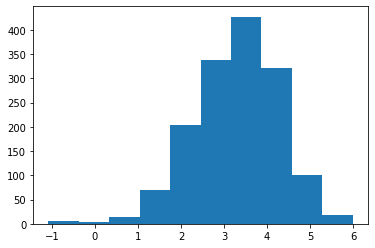

In [12]:
plt.hist(medi_target[:,2])

(array([  5.,   6.,  23.,  84., 201., 355., 407., 294., 105.,  20.]),
 array([-0.35469204,  0.25877017,  0.8722324 ,  1.4856946 ,  2.0991569 ,
         2.712619  ,  3.3260813 ,  3.9395435 ,  4.5530057 ,  5.1664677 ,
         5.77993   ], dtype=float32),
 <BarContainer object of 10 artists>)

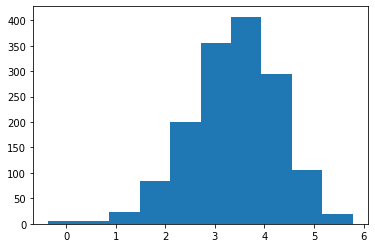

In [13]:
plt.hist(medi_projection[:,2])

### INCWAGE

(array([  3.,  10.,  16.,  46., 154., 372., 462., 332.,  88.,  17.]),
 array([ 3.73766962,  4.72704941,  5.7164292 ,  6.70580899,  7.69518878,
         8.68456857,  9.67394836, 10.66332815, 11.65270794, 12.64208773,
        13.63146752]),
 <BarContainer object of 10 artists>)

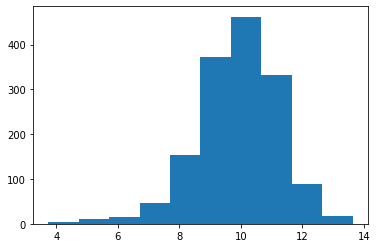

In [14]:
plt.hist(medi_target[:,3])

(array([  3.,   6.,  20.,  51., 158., 385., 470., 312.,  82.,  13.]),
 array([ 4.180146 ,  5.1362658,  6.0923853,  7.048505 ,  8.004624 ,
         8.960744 ,  9.916863 , 10.872983 , 11.8291025, 12.785222 ,
        13.741342 ], dtype=float32),
 <BarContainer object of 10 artists>)

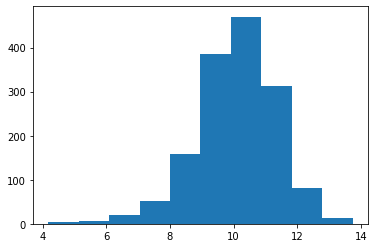

In [15]:
plt.hist(medi_projection[:,3])

## Counterfactual Data

In [16]:
def read_medicaid2(file_name, columns, sample = True):
    
    df = pd.read_csv(file_name)[columns]
    
    if sample:
        df = df.sample(7775, random_state = 31) #7775 is minimum data size
    
    return(np.array(df)) 

In [17]:
postintv = []
import glob

# check path
for file in sorted(glob.glob("Data/Medicaid Data/Counterfactual/*.csv")):
    postintv.append(read_medicaid2(file, columns1))

postintv.insert(0, postintv.pop(5)) # Move Montana to front of list(why is mt 12?)
post_target = postintv[0]
post_controls = postintv[1:]

mt_years = read_medicaid2("Data/Medicaid Data/Counterfactual/MT_post.csv", ['YEAR'])

In [18]:
post_projection = sum([a*b for a,b in zip(medi_weights, post_controls)])
post_projection[:,0:2] = post_projection[:,0:2].round(decimals = 0).astype('int32')

### HINSCAID

Text(0.02, 0.5, 'Proportion')

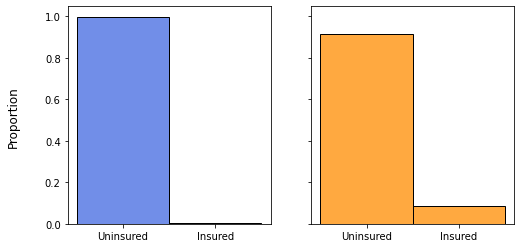

In [19]:
fig, axes = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Uninsured' , 2: 'Insured'}
reptemp = pd.DataFrame(post_projection[:,0])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(post_target[:,0])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes[1], discrete = True, stat = 'density', color = 'darkorange')
axes[0].set(xlabel = None, ylabel = None)
axes[1].set(xlabel = None, ylabel = None)

fig.supylabel('Proportion')
#plt.savefig('plots/hinscaid_sep.png')

### EMPSTAT

Text(0.02, 0.5, 'Proportion')

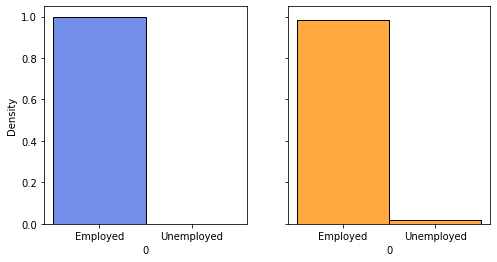

In [20]:
fig2, axes2 = plt.subplots(1,2, figsize = (8,4), sharex = True, sharey = True)

dict_map = {1:'Employed' , 2: 'Unemployed'}
reptemp = pd.DataFrame(post_projection[:,1])
reptemp[0] = reptemp[0].map(dict_map)

targtemp = pd.DataFrame(post_target[:,1])
targtemp[0] = targtemp[0].map(dict_map)

sns.histplot(reptemp, x = 0, ax = axes2[0], discrete = True, stat = 'density', color = 'royalblue')
sns.histplot(targtemp, x = 0, ax = axes2[1], discrete = True, stat = 'density', color = 'darkorange')
axes[0].set(xlabel = None, ylabel = None)
axes[1].set(xlabel = None, ylabel = None)

fig.supylabel('Proportion')

#plt.savefig('plots/empstat_sep.png')

### UHRSWORK

<AxesSubplot:ylabel='Density'>

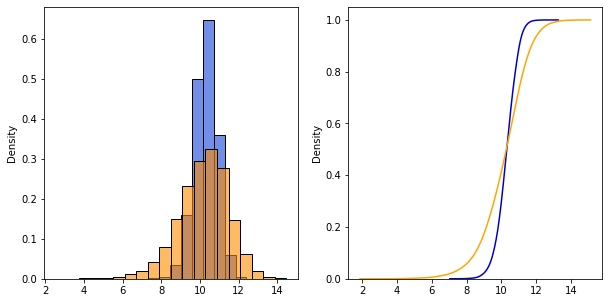

In [21]:
fig3, axes3 = plt.subplots(1,2, figsize = (10,5))
sns.histplot(post_projection[:,3], bins = 10, ax = axes3[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_projection[:,3], cumulative = True, ax = axes3[1], color = 'mediumblue')


sns.histplot(post_target[:,3], bins = 20, ax = axes3[0], color = 'darkorange', stat = 'density', alpha = 0.6)
sns.kdeplot(post_target[:,3], cumulative = True, ax = axes3[1], color = 'orange')

#plt.savefig('plots/incwage_superimposed.png')

### INCWAGE

<AxesSubplot:ylabel='Density'>

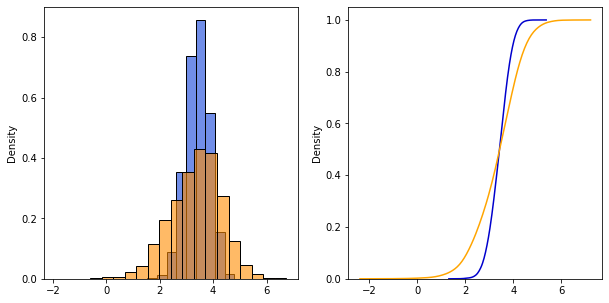

In [22]:
fig4, axes4 = plt.subplots(1,2, figsize = (10,5))
sns.histplot(post_projection[:,2], bins = 10, ax = axes4[0], color = 'royalblue', stat = 'density')
sns.kdeplot(post_projection[:,2], cumulative = True, ax = axes4[1], color = 'mediumblue')


sns.histplot(post_target[:,2], bins = 20, ax = axes4[0], color = 'darkorange', stat = 'density', alpha = 0.6)
sns.kdeplot(post_target[:,2], cumulative = True, ax = axes4[1], color = 'orange')

#plt.savefig('plots/uhrswork_superimposed.png')